In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
#from datetime import datetime as dt
# finance module is no longer part of matplotlib
# run: pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
from mpl_finance import candlestick_ohlc as candlestick
from mpl_finance import volume_overlay3
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import datetime


### The following Python libraries are used
>*   numpy 1.14.3
*   pandas 0.23.0
*   matplotlib 2.2.2
*   seaborn 0.8.1
*   scipy 1.1.0
*   statsmodels 0.9.0

### *** About the Data (bitstampUSD) ***
> 1. time_stamp (in unix time)
> 2. volume (BTC) - Volume of BTC transacted 
> 3. price (Currency)- Bitcoin price in Currency units 
> 4. data collected over 21 days starts from 28th September 2018 to 18th October 2018


<font color='black'>
### Questions 1:
====================================================================================================================== <br>
> ** Create tick, volume, and dollar bars. (Bar must have open, high, low, and close values.) Students can do this from first principles or clone the following repo for an implementation. **
    
====================================================================================================================== 

In [2]:
def create_bar(dataframe, column_, units):
    _bars_ = dataframe.copy()
    #print(_bars_)
    if column_ == 'time_stamp':
        _bars_= _bars_.resample(str(units)+'T', label='right').agg({"price":'ohlc',"volume":'sum','transaction':'sum'})
        #print(_bars_)
        _bars_.columns = _bars_.columns.droplevel()
        #print(_bars_)
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        #print(_bars_)
    else:
        if column_ == 'id':
            _bars_[column_] =1
        #print(_bars_)
    
        _bars_['filter'] = _bars_[column_].cumsum()
        #print(_bars_)
        _bars_['group']= 0
        #print(_bars_)
        n = 0
        _bars_['filter'] = _bars_['filter']/units
        #print(_bars_)
        _bars_['filter'] = _bars_['filter'].astype(int)
        #print(_bars_)
        _bars_['group']= _bars_['filter']
        #print(_bars_)
        _bars_ = _bars_.groupby('group').agg({"time_stamp":"last","price":'ohlc',"volume":'sum','transaction':'sum'})
        #print(_bars_)
        
        _bars_.columns = _bars_.columns.droplevel()
        #print(_bars_)
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        #print(_bars_)
        _bars_ = _bars_.set_index('time_stamp')
        #print(_bars_)
    
    return _bars_

In [3]:
def PlotCandlesticks(r):
    candlesticks = zip(date2num(r.time_stamp),r['open'],r['high'],r['low'],r['close'],r['volume'])

    fig = plt.figure()
    #ax1 = plt.subplot2grid((1,1), (0,0))
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax1 = fig.add_subplot(1,1,1)

    ax1.set_ylabel('Quote ($)', size=20)
    candlestick(ax1, candlesticks,width=.02,colorup='g', colordown='r')

    # shift y-limits of the candlestick plot so that there is space at the bottom for the volume bar chart
    pad = 0.25
    yl = ax1.get_ylim()
    ax1.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])

    # format the x-ticks with a human-readable date. 
    xt = ax1.get_xticks()
    new_xticks = [datetime.date.isoformat(num2date(d)) for d in xt]
    ax1.set_xticklabels(new_xticks,rotation=45, horizontalalignment='right')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90)
    ax1.grid(True)
    plt.ion()
    plt.show()


In [4]:
# Daily Volatility Estimator 

# daily vol reindexed to close of each bar
def getDailyVol(close,span0=100):
    
    # substract one day from each datetime timestamp index field
    dftemp=close.index-pd.Timedelta(days=1) 
    #search for new dates in original timestamp index field. writes 0 if not found, row number if found
    df0=close.index.searchsorted(dftemp) 
    #remove entries that have 0, i.e. rows that didn't have a day earlier match
    df0=df0[df0>0]
    #create a new dataframe that has the original dates as index, and the new dates as second column
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # calculate daily returns for each bar
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
        
    #calculate volatility for each bar based on std deviation of the daily return of that bar
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [5]:
path = os.getcwd()

In [6]:
data = pd.read_csv(path+'/bitstampUSD_21.csv')
data['transaction'] = data['price'] * data['volume']
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data.index = data['time_stamp']
print(data)
    

                             time_stamp    price    volume   transaction
time_stamp                                                              
2018-07-28 00:00:06 2018-07-28 00:00:06  8177.72  0.046752    382.321576
2018-07-28 00:00:07 2018-07-28 00:00:07  8182.84  0.023810    194.830884
2018-07-28 00:00:16 2018-07-28 00:00:16  8182.84  0.013163    107.708268
2018-07-28 00:00:16 2018-07-28 00:00:16  8184.35  0.049576    405.750036
2018-07-28 00:00:16 2018-07-28 00:00:16  8184.36  0.047594    389.524302
2018-07-28 00:00:19 2018-07-28 00:00:19  8187.11  0.000691      5.654837
2018-07-28 00:00:19 2018-07-28 00:00:19  8187.11  0.046061    377.105737
2018-07-28 00:00:23 2018-07-28 00:00:23  8187.11  0.011904     97.461732
2018-07-28 00:00:26 2018-07-28 00:00:26  8181.89  0.054402    445.107825
2018-07-28 00:00:27 2018-07-28 00:00:27  8187.13  0.100000    818.713000
2018-07-28 00:00:27 2018-07-28 00:00:27  8188.48  1.000000   8188.480000
2018-07-28 00:00:30 2018-07-28 00:00:30  8184.60  0

In [7]:
dollar_bars = create_bar(data, 'transaction', 500000)
dollar_bars.to_csv(path+"/dollar_bars.csv")



PermissionError: [Errno 13] Permission denied: 'F:\\GDrive\\_WQU MSFE\\Classes\\ML\\code\\WQU-Project-Submission2\\WQU-Project-Submission2/dollar_bars.csv'

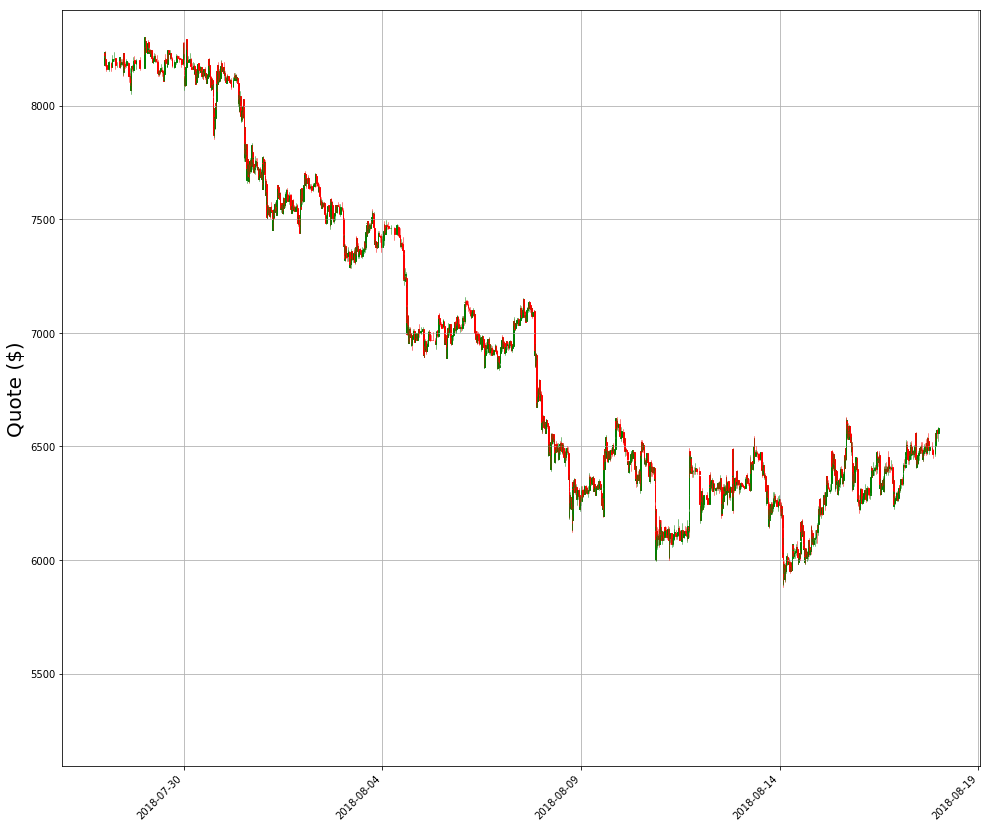

In [8]:
datafile = path+"/dollar_bars.csv"
r = mlab.csv2rec(datafile, delimiter=',')
PlotCandlesticks(r)
#print(r)


<font color='black'>
### Questions 2:
====================================================================================================================== <br>
> ** Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot the time series of the bar count. What bar type produces the most stable weekly count? And why? **  
    
======================================================================================================================


***

<font color='blue'>
### ***Analysis ***
<br>
> The Bars which has most stable weekly count is **`Time Bars`**:
* It evenly sampled across the period, though it might be high-activity period or low activity period. 
* Because of this time sampled series often exhibits poor statistical properties, it is clearly visible in below Auto Correlation plots and in Normality plot where `Time Bars` shows higher `Kurtosis`

***

<font color='black'>
### Questions 3:
====================================================================================================================== <br>    
> ** Compute the serial correlation of each bar type and report back on which method has
the lowest serial correlation. **

======================================================================================================================

In [9]:
#add a column for the returns
dollar_returns=np.log(dollar_bars['close']).diff()
#dollar_returns=(dollar_bars['close']).diff()
dollar_bars=dollar_bars.assign(dollar_returns=dollar_returns)


#add a column for the 20 period std deviation of the log of returns at each bar (volatility)
periodVol=dollar_returns.ewm(span=20).std()
print(periodVol)
dollar_bars=dollar_bars.assign(periodVol=periodVol)
print(dollar_bars[abs(dollar_returns)>periodVol])

time_stamp
2018-07-28 00:03:28         NaN
2018-07-28 00:04:18         NaN
2018-07-28 00:04:49    0.002807
2018-07-28 00:25:48    0.003785
2018-07-28 01:08:04    0.003032
2018-07-28 02:26:46    0.003625
2018-07-28 04:01:05    0.003314
2018-07-28 04:35:45    0.003495
2018-07-28 04:47:31    0.003185
2018-07-28 05:53:23    0.002897
2018-07-28 06:28:39    0.003011
2018-07-28 07:34:24    0.002793
2018-07-28 09:12:43    0.003013
2018-07-28 09:16:16    0.003355
2018-07-28 09:21:33    0.003263
2018-07-28 10:08:29    0.003056
2018-07-28 10:52:15    0.002863
2018-07-28 11:10:14    0.002780
2018-07-28 11:11:13    0.002735
2018-07-28 11:19:02    0.004283
2018-07-28 11:20:40    0.004102
2018-07-28 11:39:33    0.003976
2018-07-28 11:44:04    0.003776
2018-07-28 12:06:27    0.003583
2018-07-28 13:14:57    0.003493
2018-07-28 14:18:28    0.003662
2018-07-28 14:27:55    0.003481
2018-07-28 14:37:17    0.003321
2018-07-28 15:09:09    0.003155
2018-07-28 15:32:00    0.003216
                         ... 


***

<font color='blue'>
### ***Analysis ***
<br>
> The Bars which has lowest serial correlation **`Dollar Bars`**:
    
* A serial correlation/auto correlation in which errors in lag observation increases the probability of error for lead observation. higher positive or lower negative serial correlation increases positive errors or negative errors respectively.
* A serial correlation/auto correlation leads to misleading inferences (like increase the proneness Type-I error or inflation in T-statistics).

***

<font color='black'>
### Questions 4:
====================================================================================================================== <br>
> ** Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic? **
  
====================================================================================================================== 


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<font color='blue'>

    
Dollar bars achieves lowest test statistics, its test statistics is 52
    
> Note:
* But Jarque-Bera normality distribution is only used for large sample sizes (> 2000) generally and in our 21 days sampled data the sample size is not more than 2000 for some Bars, so this test might not be advisable.
* By looking into Kurtosis and Skewness (Fishers Method) we can easily see that Dollar Bars and Volume Bars follows Normal distribution

------------------------------------------------------------------------------------------------------------

<font color='black'>

======================================================================================================================
 ### Visual Inspection of Normality: 
====================================================================================================================== 


In [ ]:
time_diff = time_returns

volume_diff = volume_returns
dollar_diff = dollar_returns
time_standard = (time_diff - time_diff.mean()) / time_diff.std()

volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()
plt.figure(figsize=(18,10))
sns.kdeplot(time_standard, label="Time", bw=0.30, color='red',linestyle="-")

sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='green')
sns.kdeplot(dollar_standard, label="Dollar", bw=0.25, linewidth=2, color='brown')


sns.kdeplot(norm_dist, label="Normal", color='black', linestyle="--")

plt.xticks(range(-10, 10))
plt.legend(loc=7, ncol=9)
plt.title('Test of of Normality through a price with different sampling base like volume, tick, dollar clock',
          loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-10, 10)
plt.show()